In [16]:
import pandas as pd
print(pd. __version__)
from sklearn.utils import shuffle

#df = pd.read_pickle('https://pandora.infn.it/public/24236c/dl/dataset_pol_vbs_full2018v9_VBS_WW_2j_emu_dnn_ATLAS.pkl')
df = pd.read_pickle('https://pandora.infn.it/public/3dcf6d/dl/dataset_pol_vbs_full2018v9_VBS_WW_2j_emu_dnn_ATLAS_selection.pkl')
pd.set_option('display.max_columns', None)

df['notLL'] = df['isTT'] + df['isMIX']
df['notTT'] = df['isLL'] + df['isMIX']

df_SvB = df[((df['isTT'] + df['isMIX'] + df['isLL']) == 0) & ((df['isVBS'] + df['isBKG']) == 1)]
df_SvB = df_SvB[['CleanJet_pt_1', 'CleanJet_pt_2', 'mll', 'MET_significance', 'zeta', 'mjj', 'detajj', 'dphijj', 'm2ljj30', 'isLL', 'isMIX', 'isTT', 'isBKG', 'isVBS', 'notLL', 'notTT']]
df_red = df[['CleanJet_pt_1', 'CleanJet_pt_2', 'mll', 'MET_significance', 'zeta', 'mjj', 'detajj', 'dphijj', 'm2ljj30', 'isLL', 'isMIX', 'isTT', 'isBKG', 'isVBS', 'notLL', 'notTT']]
df_SvB

1.3.5


,CleanJet_pt_1,CleanJet_pt_2,mll,MET_significance,zeta,mjj,detajj,dphijj,m2ljj30,isLL,isMIX,isTT,isBKG,isVBS,notLL,notTT
0,53.054813,29.876976,119.088409,1.595703,1.021057,276.330872,3.893066,1.000959,271.210632,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,30.664513,29.299437,128.700623,15.085938,2.046753,495.311188,5.605469,1.686401,239.743408,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,30.099604,28.075436,111.508141,10.007812,0.949219,104.640396,2.666260,0.274885,156.898926,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,91.604919,32.597763,267.004730,8.101562,1.380615,551.808350,4.623047,1.564453,840.582458,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,59.228630,48.039818,81.836113,6.886719,1.799194,628.104187,4.930176,1.513550,791.871887,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32287,158.753632,80.266327,85.201508,18.312500,0.529480,1368.427856,4.981445,2.118530,1592.925781,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32288,190.165131,109.592522,112.974281,44.375000,1.710358,1039.798218,3.931885,1.972290,1177.098145,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32289,68.281357,32.656868,129.935699,3.316406,1.657227,903.292419,5.904785,1.004395,1104.163574,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32290,153.700607,113.567513,316.587463,11.273438,0.893066,2401.952637,5.796875,2.201477,3160.002930,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [17]:
import math
import numpy as np
import tensorflow as tf

In [18]:
import tqdm
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Activation, Dense, Dropout, InputLayer
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import initializers
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
import copy
print(tf.__version__)
from tensorflow.python.client import device_lib
tf.config.run_functions_eagerly(True)

2.7.0-rc1


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 150

nclasses = 2
features = df.columns[:len(df.columns)-7]

NDIM = len(features)
print(NDIM)
for col in df.columns:
    df[col]    = np.hstack(df[col])
'''
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df = shuffle(df)
'''
# Perform the splitting and define training and validation datasets
msk    = np.random.rand(len(df_SvB)) < 0.8

df_train    = df_SvB[msk]
df_val      = df_SvB[~msk]

NDIM = len(df_SvB.columns[:len(df_SvB.columns)-7])
X    = df_train.values[:,0:NDIM]
Y    = df_train[['isVBS', 'isBKG']].values
X_val = df_val.values[:,0:NDIM]
Y_val = df_val[['isVBS', 'isBKG']].values

print(X,Y)

59
[[5.30548134e+01 2.98769760e+01 1.19088409e+02 ... 3.89306641e+00
  1.00095880e+00 2.71210632e+02]
 [3.06645126e+01 2.92994366e+01 1.28700623e+02 ... 5.60546875e+00
  1.68640137e+00 2.39743408e+02]
 [3.00996037e+01 2.80754356e+01 1.11508141e+02 ... 2.66625977e+00
  2.74884522e-01 1.56898926e+02]
 ...
 [1.90165131e+02 1.09592522e+02 1.12974281e+02 ... 3.93188477e+00
  1.97229004e+00 1.17709814e+03]
 [6.82813568e+01 3.26568680e+01 1.29935699e+02 ... 5.90478516e+00
  1.00439453e+00 1.10416357e+03]
 [1.53700607e+02 1.13567513e+02 3.16587463e+02 ... 5.79687500e+00
  2.20147705e+00 3.16000293e+03]] [[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [22]:
class SimpleNeuralNetwork ( tf.Module ):
    def __init__ (self, nEpochs, learning_rate, N_NODES, n_layers, n_features, n_outputsC=nclasses, ATLAS=False):
        self.learning_rate = learning_rate
        self.optimizer  = tf.optimizers.Adam (self.learning_rate)
        self.nEpochs = nEpochs
        self.N_NODES = N_NODES
        self.n_layers = n_layers
        self.n_features = n_features
        self.n_outputsC = n_outputsC
        self.ATLAS = ATLAS
        self.weights = self.build (self.n_features, self.N_NODES)
        
                                
    # Define the structure of the model
    def build (self, n_input, N_NODES):
        # initializer = initializers.Ones()

        # Classifier model
        self.model1 = Sequential()
        #self.model1.add(Dense (self.N_NODES, activation = 'relu', input_dim  = n_input))
        if not self.ATLAS:
            for i in range(self.n_layers):
                self.model1.add(Dense (self.N_NODES, activation = 'relu', kernel_constraint=max_norm(3)))
                self.model1.add(Dropout (0.1))
        else:
            self.model1.add(Dense (108, activation = 'relu', kernel_constraint=max_norm(3), input_dim = n_input))
            self.model1.add(Dropout (0.1))
            self.model1.add(Dense (60, activation = 'relu', kernel_constraint=max_norm(3)))
            self.model1.add(Dropout (0.1))
        if self.n_outputsC > 1:
            self.model1.add(Dense (self.n_outputsC, activation = 'softmax',input_dim = self.N_NODES))
        else:
            self.model1.add(Dense (self.n_outputsC, activation = 'sigmoid',input_dim = self.N_NODES))
        
        return self.model1.weights
     
    # Performs the epochs loop and the actual training.
    # Monitors the training and validation loss functions, both for the classifier and the adversary.
    # Returns the classifier categorical accuracy.
    def fit (self, X, Y, X_val, Y_val, show_loss = False):
        losses = []
        losses_val = []

        self.means = np.mean ( X, axis = 0)
        self.sigmas = np.std ( X, axis = 0)

        for iEpoch in tqdm.tqdm(range(self.nEpochs)):
                l, l_val = self._train (X, Y, X_val, Y_val)
                losses.append ( l )
                losses_val.append ( l_val )

        losses = np.array(losses)               
        losses_val = np.array(losses_val)
               
        plt.plot (losses, color = "c", label='Training set')
        plt.plot (losses_val, color ='tab:blue', label = "Validation set")
        plt.xlabel ("Epoch"); plt.ylabel ("Loss")
        plt.legend(frameon=False)
        plt.show()
         
        ca = tf.keras.metrics.CategoricalAccuracy()
        if self.n_outputsC <= 1:
            ca = tf.keras.metrics.BinaryAccuracy()
        ca.update_state(Y, self.predict_proba(X))
        
        return ca.result().numpy()

    def save_weights(self, model_name):
        self.model1.save_weights(model_name+'_weights_1')
    
    def load_weights(self, model_name):
        self.model1.load_weights(model_name+'_weights_1')
        
    def save_model(self, model_name):
        self.model1.save("saved_models/"+model_name+"_1")

    def reset_optimizers(self):
        self.optimizer  = tf.optimizers.Adam (self.learning_rate)
        
    def set_epochs(self, epochs):
        self.nEpochs = epochs
        
    # Applies a pre-processing to the input features and returns the classifier representation.
    #@tf.function
    def predict_proba (self, X):
        ppX = (X - self.means)/self.sigmas
        return  tf.clip_by_value ( self.model1 (ppX) , 1e-7, 1. - 1e-7 )


    @tf.function
    def _train (self, X, Y, X_val, Y_val):
        Y_true = tf.cast (Y, tf.float32)
        Y_true_val = tf.cast (Y_val, tf.float32)

        with tf.GradientTape() as gt:
            #gt.watch ( self.weightsC )
            Y_hat = self.predict_proba (X)
            Y_hat_val = self.predict_proba (X_val) #N3(N1(x)) validation set
            
            ## Training set
            # Use the categorical cross-entropy as loss function for the classifier
            cce = 0.
            cce_val = 0.
            bce = 0.
            bce_val = 0.
            loss = 0.
            loss_val = 0.
            
            if self.n_outputsC > 1:
                cce = tf.keras.losses.CategoricalCrossentropy()
                loss = tf.reduce_mean ( cce( Y_true, Y_hat ) )
            
                ## Validation set
                cce_val = tf.keras.losses.CategoricalCrossentropy()
                loss_val = tf.reduce_mean (cce_val( Y_true_val, Y_hat_val ) )
            else:
                bce = tf.keras.losses.BinaryCrossentropy()
                loss = tf.reduce_mean ( bce( Y_true, Y_hat ) )
            
                ## Validation set
                bce_val = tf.keras.losses.BinaryCrossentropy()
                loss_val = tf.reduce_mean (bce_val( Y_true_val, Y_hat_val ) )
            
            # Compute the gradient of the overall loss with respect to the classifier weights
            gradients = gt.gradient ( loss, self.weights )

        # Apply the gradients
        self.optimizer.apply_gradients ( zip(gradients, self.weights) )
        
        return loss, loss_val

In [32]:
dnn = SimpleNeuralNetwork(300, learning_rate=0.001, N_NODES=50, n_layers=8, n_features=X.shape[1], n_outputsC=2, ATLAS=True)
dnn.save_weights("ATLAS_selection_SigVsBkg_emu")

In [33]:
print(X.shape, Y.shape)
print(X)

(25838, 9) (25838, 2)
[[5.30548134e+01 2.98769760e+01 1.19088409e+02 ... 3.89306641e+00
  1.00095880e+00 2.71210632e+02]
 [3.06645126e+01 2.92994366e+01 1.28700623e+02 ... 5.60546875e+00
  1.68640137e+00 2.39743408e+02]
 [3.00996037e+01 2.80754356e+01 1.11508141e+02 ... 2.66625977e+00
  2.74884522e-01 1.56898926e+02]
 ...
 [1.90165131e+02 1.09592522e+02 1.12974281e+02 ... 3.93188477e+00
  1.97229004e+00 1.17709814e+03]
 [6.82813568e+01 3.26568680e+01 1.29935699e+02 ... 5.90478516e+00
  1.00439453e+00 1.10416357e+03]
 [1.53700607e+02 1.13567513e+02 3.16587463e+02 ... 5.79687500e+00
  2.20147705e+00 3.16000293e+03]]


100%|██████████| 300/300 [00:05<00:00, 55.88it/s]


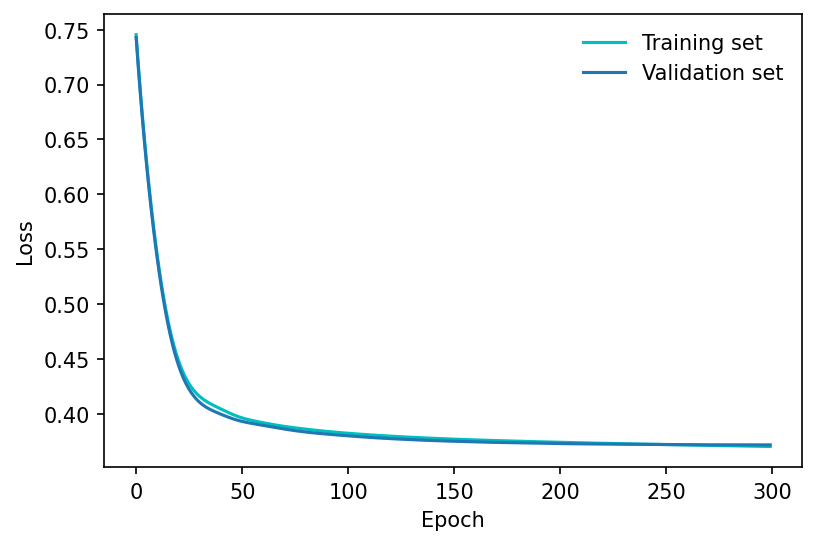

In [34]:
acc = dnn.fit (X.astype(np.float32), Y.astype(np.float32), X_val.astype(np.float32), Y_val.astype(np.float32))

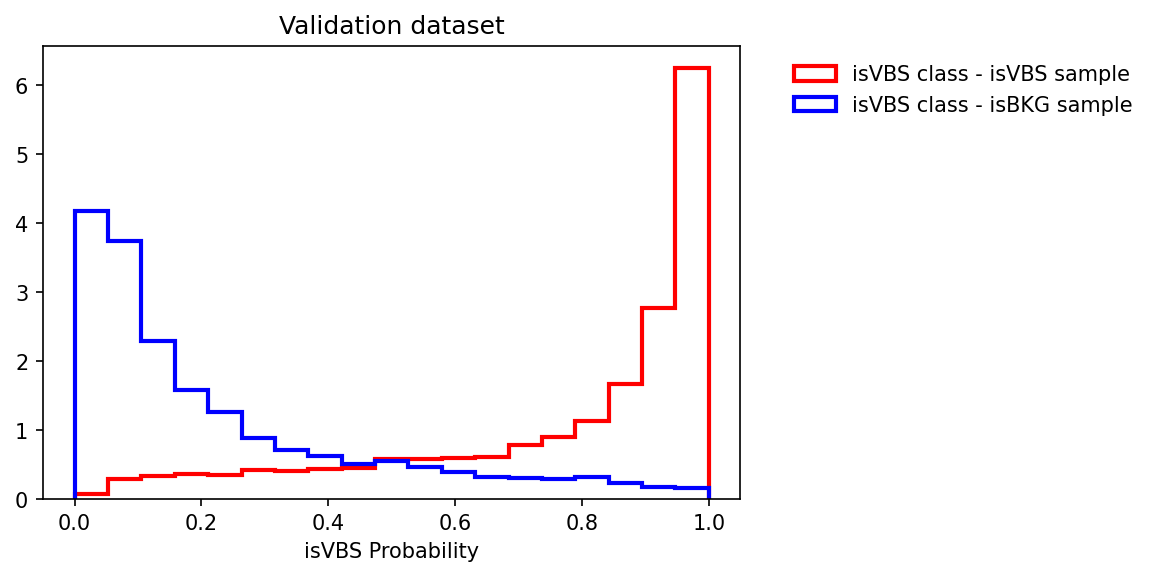

In [35]:
Y_predict_train = dnn.predict_proba(X)
Y_predict_val = dnn.predict_proba(X_val)

axis = np.linspace(0,1,20)

targets = ['isVBS', 'isBKG']
predictions = ['isVBS']
colors = ['r', 'b']
 
Y_targets = {}
Y_predictions = {}

for target in targets:
    Y_targets[target] = dnn.predict_proba( df_val[ df_val[target]==1 ].values[:,0:NDIM] )
    Y_predictions[target] = {}
    for iprediction, prediction in enumerate(predictions):
        Y_predictions[target][prediction] = Y_targets[target][:,iprediction]

for prediction in predictions:
    for target, mycolor in zip(targets, colors):
        plt.hist(Y_predictions[target][prediction].numpy(), bins = axis, label = prediction + ' class - ' + target + ' sample', histtype='step', color=mycolor,  density=True, linewidth=2 )
    plt.title('Validation dataset')
    plt.xlabel(prediction + ' Probability')
    plt.legend(frameon=False, bbox_to_anchor=(1.05, 1.))
    #plt.yscale('log')
    plt.show()

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
#from matplotlib.backends.backend_pdf import PdfPages

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 16)
    plt.yticks(tick_marks, classes, fontsize = 16)

    thresh = cm.max() / 1.2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize=10)

    plt.xlabel("Predicted label", fontsize=16)
    plt.ylabel("True label", fontsize=16)

    
    plt.tight_layout()

In [37]:
from sklearn.metrics import accuracy_score
from scipy.stats import ks_2samp, anderson_ksamp

X = df_val.values[:,0:NDIM]
Y_true = df_val[['isVBS', 'isBKG']].values
Y_pred = dnn.predict_proba(X)

# The classifier categorical accuracy is a good and simple metrics to evaluate the overall classification performance
Y_true_max = np.argmax(Y_true, axis=1)
Y_pred_max = np.argmax(Y_pred, axis=1)
print("Classifier categorical accuracy = ", accuracy_score(Y_true_max, Y_pred_max))

Classifier categorical accuracy =  0.8325069724202045


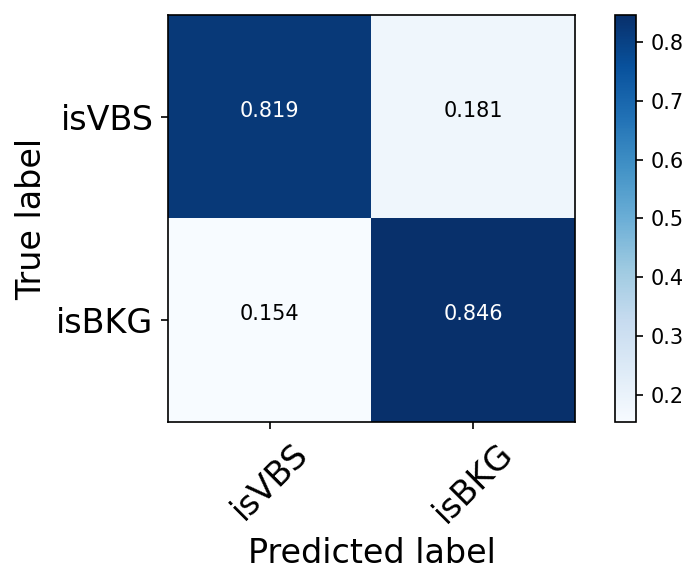

In [38]:
C = confusion_matrix(Y_true_max, Y_pred_max, normalize="true")
C = np.around(C, decimals=3)

plt.figure()
plot_confusion_matrix(C, classes=['isVBS', 'isBKG'], title='')
plt.show(1) 

In [15]:
with open('generated_code_ATLAS_dnn_SigVsBkg_emu.h', 'w') as f:


    print ("""
    // Select all (Ctrl+A), Copy (Ctrl+C), paste to an empty text file (Ctrl+V) and save that file as 'generated_code.h'
    // 
    // Auto-generated header file. Assumes img to be a floating point array
    // of 64 elements (corresponding to an 8x8 b&w image)

    #include <math.h>

    float norma_VBS;
    """, file=f)
    
    iLayer_tmp=-1

    for iLayer, layer in enumerate(dnn.model1.layers):
      print(type(layer))
#       if type(layer) is not Dropout and type(layer) is not Input :
      if type(layer) is Dense:
        kernel, bias = layer.get_weights()
        iLayer_tmp+=1
        print ("inline float activation_VBS_%d (float x, float n) " % iLayer_tmp, file=f);
        activation =  layer.get_config()['activation'] 
        if activation == 'sigmoid':
          print ("{ return 1./(1 + exp(-x)); }", file=f)
        elif activation == 'tanh':
          print ("{ return tanh(x);}")
        elif activation == 'relu':
          print ("{ return x > 0 ? x : 0;}", file=f)
        elif activation == 'linear':
          print ("{ return x;}")
        elif activation == 'softmax':
          print ("{ return exp(x)/n;  }", file=f)
        else:
          raise KeyError ("Unexpected activation %s"%activation)
      
    iLayer_tmp=-1

    
    print ("""
    float guess_VBS (const float *img, int flag)
    {
    """, file=f)

    max_out = 100
    for iLayer, layer in enumerate(dnn.model1.layers):
      if type(layer) is Dense:
        iLayer_tmp+=1
        print ("  // Declare the arrays in the stack", file=f)
        kernel, bias = layer.get_weights()
        
        print (type (dnn.means))
        print (type(bias))
        
         
        max_out = max(kernel.shape[1], max_out)
        #print ("  //",bias.shape)
        kernel_values = "{%s}"%(',\n   '.join(["{%s}"%(','.join(["%18.13f"%x for x in row])) for row in kernel]))
        bias_values   = "{%s}"% ( ",".join(["%18.13f"%x for x in bias]))
        print ("  const float kernel_%d[%d][%d] = \n  %s;" % (iLayer_tmp, kernel.shape[0], kernel.shape[1],kernel_values), file=f)
        print ("  const float bias_%d[%d] = %s;" % (iLayer_tmp, bias.shape[0], bias_values), file=f)
      
    print ("  float buffer_in[%d];" % max_out, file=f)
    print ("  float buffer_out[%d];" % max_out, file=f)

    print ("  unsigned int i,j,c; ", file=f)
    

    mean_values = "{%s}"% ( ",".join(["%18.13f"%x for x in dnn.means]))
    sigma_values = "{%s}"% ( ",".join(["%18.13f"%x for x in dnn.sigmas]))
    

    print (" float mean[%d] = %s;" % (max_out, mean_values), file=f)
    print (" float sigma[%d] = %s;" % (max_out, sigma_values), file=f)

    print ("\n\n\n", file=f)
    print ("  // Load the input in the buffer", file=f)
    print ("  for (c = 0; c < 64; ++c) \n  buffer_in[c] = (img[c]-mean[c])/sigma[c];", file=f)



    iLayer_tmp=-1

    for iLayer, layer in enumerate(dnn.model1.layers):
      if type(layer) is Dense: 
        kernel, bias = layer.get_weights()
        iLayer_tmp+=1

        if iLayer != len(dnn.model1.layers)-1:
            
            
            print ( "  // Processing layer %i " % iLayer_tmp , file=f)
            print ( """
            for (c = 0; c < {n_out}; ++c ) 
              buffer_out[c] = bias_{iLayer_tmp}[c];

            for (c = 0; c < {n_out}; ++c )
              for (i = 0; i < {n_in}; ++i)
                buffer_out[c] += buffer_in[i] * kernel_{iLayer_tmp}[i][c];

            norma_VBS = 0;

            // Prepares for next layer 
            for (c = 0; c < {n_out}; ++c )
              buffer_in[c] = activation_VBS_{iLayer_tmp}(buffer_out[c], norma_VBS);


            """.format (
                n_in = kernel.shape[0],
                n_out = kernel.shape[1],
                iLayer_tmp = iLayer_tmp,
            ), file=f)
            
        else:
            
            print ( "  // Processing layer %i " % iLayer_tmp , file=f)
            print ( """
            for (c = 0; c < {n_out}; ++c ) 
              buffer_out[c] = bias_{iLayer_tmp}[c];

            for (c = 0; c < {n_out}; ++c )
              for (i = 0; i < {n_in}; ++i)
                buffer_out[c] += buffer_in[i] * kernel_{iLayer_tmp}[i][c];

            norma_VBS = 0;

            for(c=0;c<{n_out};++c)
              norma_VBS+=exp(buffer_out[c]);

            // Prepares for next layer 
            for (c = 0; c < {n_out}; ++c )
              buffer_in[c] = activation_VBS_{iLayer_tmp}(buffer_out[c], norma_VBS);


            """.format (
                n_in = kernel.shape[0],
                n_out = kernel.shape[1],
                iLayer_tmp = iLayer_tmp,
            ), file=f)
      
    last_kernel, last_bias = dnn.model1.layers[-1].get_weights()
    print ("""
      //i = 0;
      //for (c = 0; c < {n_out}; ++c)
      //  if (buffer_in[c] > buffer_in[i])
      //    i = c;
      
      if (flag==0) //vbf
        return buffer_in[0];
      else if (flag==1) //bkg
        return buffer_in[1];
         
      
      //return i;
    """.format(n_out = last_kernel.shape[1]), file=f)

    print ("}", file=f)

<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dropout.Dropout'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dropout.Dropout'>
<class 'keras.layers.core.dense.Dense'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
